In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

**TODOs**

0. Priorities
   1. $\checkmark$ ~~Remove the target feature for the pipeline?~~
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
    
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~

3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?

4. More EDA
    * Identify quantities to be removed:
        * $\checkmark$ ~~IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution~~ $\to$ _this led to a big step in improvement_
            * ~~or see if they're correlated with another feature, like 'sub_area'~~ $\to$ did not find this; just removed sampled IDs
            * **open** 
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 

5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * $\checkmark$ ~~removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)~~
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ _no improvement; slightly worse with XGB_
            * $\checkmark$ removed the 'sub_area' feature entirely $\to$ _no improvement_
            * **TODO** try with other classifiers

6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 

            
**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [4]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
import os

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [8]:
#import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [9]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [10]:
df.shape

(30471, 292)

Get the dtypes of the DF; save to a dict for later use

In [11]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
df_dtype_dict = dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

## Preprocess the data

### Feature work: the target

#### Separate the target feature

**Note** the target feature may also need to be transformed, _e.g._ rescaled

In [12]:
target_feature = 'price_doc'
target_col = [target_feature]

In [13]:
df[target_col].head()

,price_doc
0,5850000
1,6000000
2,5700000
3,13100000
4,16331452


In [14]:
df_targ = df[['id']+target_col].copy()

In [15]:
df = df.drop(columns=target_feature)

In [16]:
#feature_importance_dropped_cols = ['incineration_raion', 'big_market_raion', 'sub_area']
#df = df.drop(columns=feature_importance_dropped_cols)

#### Inspect and clean the target

In [17]:
df_targ['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [18]:
targ_vals = df_targ['price_doc'].values

In [19]:
bin_width = 1e5
bins=np.arange(bin_width, 1.2e8 + bin_width, bin_width)
print(len(bins))

1200


In [20]:
hist_df_price_doc, _ = np.histogram(targ_vals, bins=bins, density=False)

In [21]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

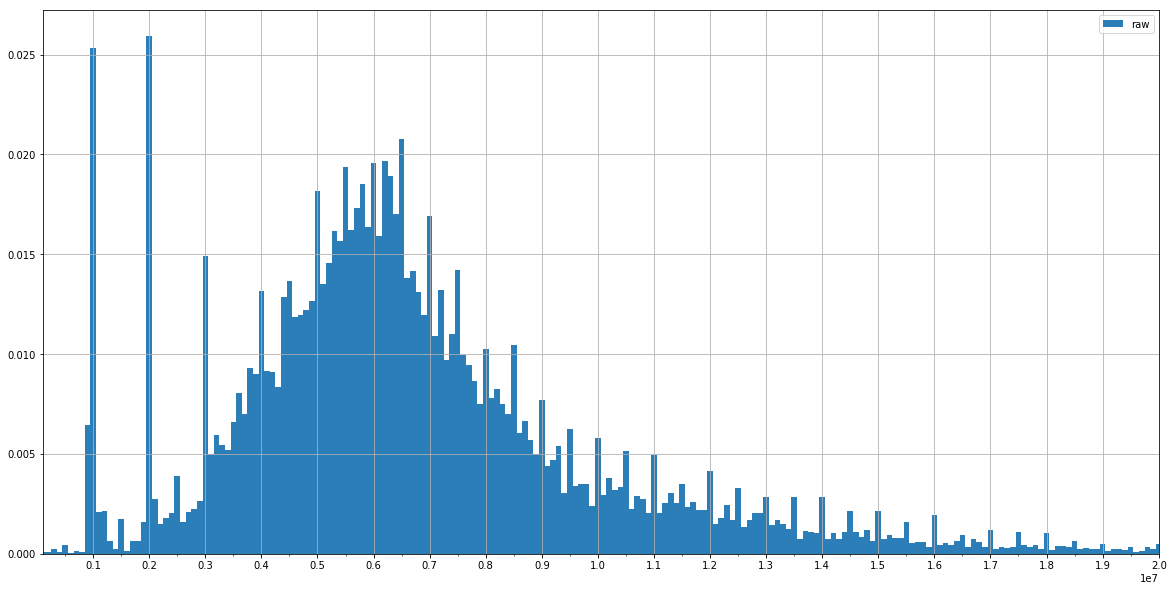

In [22]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_df_price_doc/30471.0, width=bin_width, label='raw', alpha=0.95)

#ax.set_xticks(np.arange(0,1e7,1e6), minor=True)
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1e6))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5e5))


ax.set_xlim(1e5, 2e7)
ax.legend()
ax.grid();

**Notes** there are spikes in price values for every interval of 500k CURRENCY; some are reasonable, but mostly they appear distinct. 
Such spikes could be due to some mechanism which (due to their lack of counts) would not be picked up in a model.

In [23]:
peaks = np.arange(1,20.5,0.5)*1e6 

In [24]:
def get_smooth_ids1(df, identifier, target, peaks, bin_width, verbose=False):
       
    df_cp = df.copy()
    
    target_bin = target + "_bin"
    
    df_cp[target_bin] = df_cp[target].apply(lambda x: x-x%bin_width)
    
    # The the counts of the nearby bins, then average for a sample from the outlier bin
    avg_counts = []
    for z in peaks:

        lo = df_cp[(df_cp[target]==z-bin_width)][target].count()
        sp = df_cp[(df_cp[target]==z)][target].count()
        hi = df_cp[(df_cp[target]==z+bin_width)][target].count()  

        avg = 0.5*(lo+hi)

        if verbose: print(z,'\t',lo,'\t', sp,'\t', hi, '\t', avg)    

        avg_counts.append(avg)

        
    # 1. Sample from the outlier bin
    # 2. remove the outlier bin
    # 3. replace the outlier bin with a subsample
    # NOTE: Either we sample 
    #   1. from the bin, or 
    #   2. from a specific outlying value ==> target_bin = target    
    target_bin = target
    if verbose: print('\nStarting with:', df_cp.shape)
    for n,z in enumerate(peaks):

        samp_size = int(avg_counts[n])
        if verbose: print(f'{z}:', int(samp_size))

        # See NOTE above
        #df_samp = df_cp[df_cp[target_bin]==z]            
        df_samp = df_cp[df_cp[target_bin]==z]
        
        if verbose: print('1',df_cp.shape, df_samp.shape)   
            
        # There might not be enough rows to properly sample from
        alt_samp_size = df_samp.shape[0]
        df_samp = df_samp.sample(min(samp_size, alt_samp_size))
        if verbose: print('1',df_samp.shape)    

        
        df_cp.where(df_cp[target_bin]!=z, inplace=True)
        df_cp.dropna(inplace=True)
        if verbose: print('2',df_cp.shape)

        df_cp = pd.concat([df_cp, df_samp])
        if verbose: print('3',df_cp.shape)

        if verbose: print()

    if verbose: print('Ending with:', df_cp.shape)    
    
    # Finally remove the dropped rows
    id_list = df_cp.dropna()[identifier].tolist()
    
    return id_list

In [25]:
def get_smooth_ids2(df, identifier, target, peaks, bin_width, verbose=False):
       
    df_cp = df.copy()
    
    target_bin = target + "_bin"
    
    df_cp[target_bin] = df_cp[target].apply(lambda x: x-x%bin_width)
    
    # The the counts of the nearby bins, then average for a sample from the outlier bin
    avg_counts = []
    for z in peaks:

        lo = df_cp[(df_cp[target_bin]==z-bin_width)][target].count()
        sp = df_cp[(df_cp[target_bin]==z)][target].count()
        hi = df_cp[(df_cp[target_bin]==z+bin_width)][target].count()  

        avg = 0.5*(lo+hi)

        if verbose: print(z,'\t',lo,'\t', sp,'\t', hi, '\t', avg)    

        avg_counts.append(avg)

        
    # 1. Sample from the outlier bin
    # 2. remove the outlier bin
    # 3. replace the outlier bin with a subsample
    # NOTE: Either we sample 
    #   1. from the bin, or 
    #   2. from a specific outlying value ==> target_bin = target    

    if verbose: print('\nStarting with:', df_cp.shape)
    for n,z in enumerate(peaks):

        samp_size = int(avg_counts[n])
        if verbose: print(f'{z}:', int(samp_size))

        # See NOTE above
        #df_samp = df_cp[df_cp[target_bin]==z]            
        df_samp = df_cp[df_cp[target_bin]==z]
        
        if verbose: print('1',df_cp.shape, df_samp.shape)   
            
        # There might not be enough rows to properly sample from
        alt_samp_size = df_samp.shape[0]
        df_samp = df_samp.sample(min(samp_size, alt_samp_size))
        if verbose: print('1',df_samp.shape)    

        
        df_cp.where(df_cp[target_bin]!=z, inplace=True)
        df_cp.dropna(inplace=True)
        if verbose: print('2',df_cp.shape)

        df_cp = pd.concat([df_cp, df_samp])
        if verbose: print('3',df_cp.shape)

        if verbose: print()

    if verbose: print('Ending with:', df_cp.shape)    
    
    # Finally remove the dropped rows
    id_list = df_cp.dropna()[identifier].tolist()
    
    return id_list

In [32]:
def get_smooth_ids3(df, identifier, target, peaks, bin_width, verbose=False):
       
    df_cp = df.copy()
    
    target_bin = target + "_bin"
    
    df_cp[target_bin] = df_cp[target].apply(lambda x: x-x%bin_width)
    
    # The the counts of the nearby bins, then average for a sample from the outlier bin
    avg_counts = []
    for z in peaks:

        lo = df_cp[(df_cp[target_bin]==z-bin_width)][target].count()
        sp = df_cp[(df_cp[target]==z)][target].count()
        hi = df_cp[(df_cp[target_bin]==z+bin_width)][target].count()  

        avg = 0.5*(lo+hi)

        if verbose: print(z,'\t',lo,'\t', sp,'\t', hi, '\t', avg)    

        avg_counts.append(avg)

        
    # 1. Sample from the outlier bin
    # 2. remove the outlier bin
    # 3. replace the outlier bin with a subsample
    # NOTE: Either we sample 
    #   1. from the bin, or 
    #   2. from a specific outlying value ==> target_bin = target    
    target_bin = target
    if verbose: print('\nStarting with:', df_cp.shape)
    for n,z in enumerate(peaks):

        samp_size = int(avg_counts[n])
        if verbose: print(f'{z}:', int(samp_size))

        # See NOTE above
        #df_samp = df_cp[df_cp[target_bin]==z]            
        df_samp = df_cp[df_cp[target_bin]==z]
        
        if verbose: print('1',df_cp.shape, df_samp.shape)   
            
        # There might not be enough rows to properly sample from
        alt_samp_size = df_samp.shape[0]
        df_samp = df_samp.sample(min(samp_size, alt_samp_size))
        if verbose: print('1',df_samp.shape)    

        
        df_cp.where(df_cp[target_bin]!=z, inplace=True)
        df_cp.dropna(inplace=True)
        if verbose: print('2',df_cp.shape)

        df_cp = pd.concat([df_cp, df_samp])
        if verbose: print('3',df_cp.shape)

        if verbose: print()

    if verbose: print('Ending with:', df_cp.shape)    
    
    # Finally remove the dropped rows
    id_list = df_cp.dropna()[identifier].tolist()
    
    return id_list

In [33]:
id_list1 = get_smooth_ids1(df_targ, 'id', 'price_doc', peaks, 1.0*bin_width, False) 
id_list2 = get_smooth_ids2(df_targ, 'id', 'price_doc', peaks, 1.0*bin_width, False) 
id_list3 = get_smooth_ids3(df_targ, 'id', 'price_doc', peaks, 1.0*bin_width, False) 

In [28]:
bars = False

In [34]:
hist_df_price_doc1_, _ = np.histogram(df_targ[df_targ['id'].isin(id_list1)].price_doc.values, bins=bins, density=False)

hist_df_price_doc2_, _ = np.histogram(df_targ[df_targ['id'].isin(id_list2)].price_doc.values, bins=bins, density=False)

hist_df_price_doc3_, _ = np.histogram(df_targ[df_targ['id'].isin(id_list3)].price_doc.values, bins=bins, density=False)

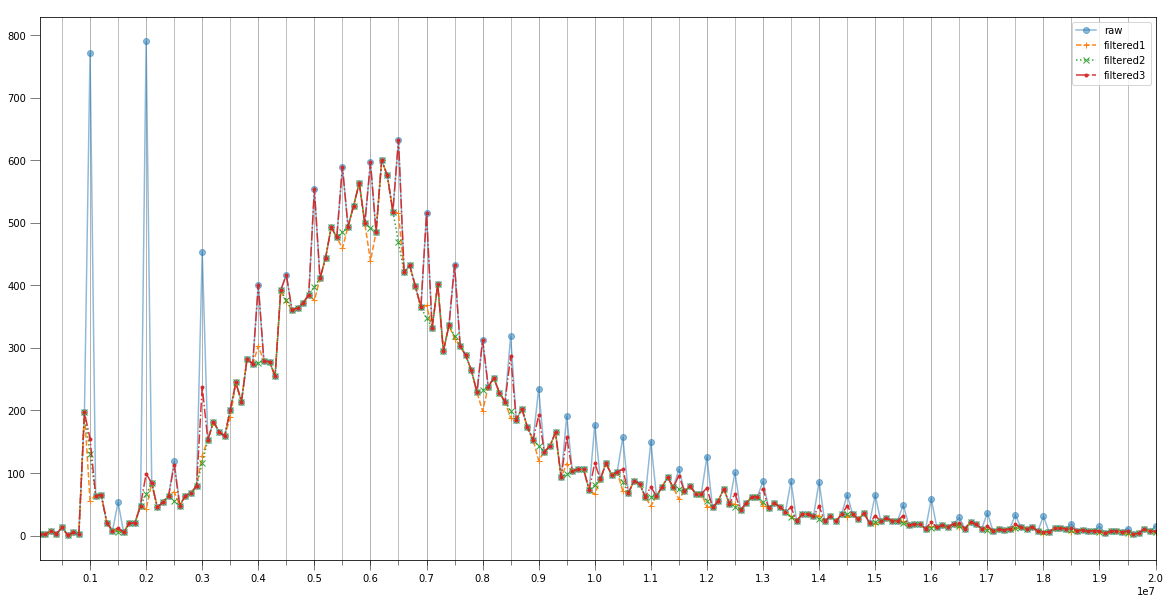

In [36]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
#ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
norma = 1.0 #30471.0

if bars:
    ax.bar( x=bins[:-1],height=hist_df_price_doc /norma, width=bin_width, label='raw', alpha=0.35)
    ax.bar( x=bins[:-1],height=hist_df_price_doc_/norma, width=bin_width/2, align='edge', label='filtered', alpha=0.95)
else:
    ax.plot(bins[:-1],hist_df_price_doc /norma, 'o-', label='raw', alpha=0.5)
    ax.plot(bins[:-1],hist_df_price_doc1_/norma, '+--', label='filtered1', alpha=0.95)
    ax.plot(bins[:-1],hist_df_price_doc2_/norma, 'x:', label='filtered2', alpha=0.95)
    ax.plot(bins[:-1],hist_df_price_doc3_/norma, '.-.', label='filtered3', alpha=0.95)
    
ax.set_xlim(1e5, 2e7)

ax.legend()

#ax.set_xticks(np.arange(0,1e7,1e6), minor=True)
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1e6))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5e5))

ax.tick_params(which='both', width=0.5)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5)

ax.grid(which='both',axis='x');

#### filter the smoothed IDs